### Objects
* map containing islands, boats move by 1 cell at each turn (cardinal directions only) and cannot cross their own route. Maps are in a coordinate system + divided into 9 squares. In silent mode, boats can move once by 4 cells in straight line. After a surface, the route is erased. One instance for own boat, one for enemy boat.
* commands:
    * sonar: the adverse team must indicate 1 correct, 1 wrong location coordinate<br>
    * torpedo: the adverse team must indicate their location square<br>
    * mine: dropped within one cell of the boat then activated at any time (except when on surface). At activation, any boat within 1 cell has 1 damage, 2 if it's exactly on the mine. Whether activated or not, a boat cannot 
    * drone: the adverse team must give their location square
* first mate weapons/navigation: torpedoes 3, mines 3, drones 4, sonar 3, silent 6. Are charged incrementally at each direction command and discharged fully every time the item is used. Records damages: the team loses when its boat meets 4.
* engineer: 4 areas for each direction, containing items corresponding to weapons/navigation. Items are marked as used at every direction command. If any category item is marked, the item cannot be used. Once an area is full, 1 damage. Some items are further grouped and can be repaired together (O orange, G grey, Y yellow, S standalone). A surface command wipes the board anew. In surface, every player must carefully draw around each area of the boat. When all 6 nuclear items are used, 1 damage.
    * W: weapon (Y) /silent (Y) /sonar (Y) / sonar (S) / nuclear x 2(S) 
    * N: silent x 2 (O) / weapon (O) / navigation (S) / weapon (S) / nuclear (S)
    * S: navigation (G) / silent (G) / weapon (G) / weapon (S) / silent (S) / nuclear (S)
    * E: navigation (O) / silent (G) / weapon (Y) / navigation (S) / nuclear x 2 (S)

In [ ]:
%load_ext autoreload
%autoreload 2

In [198]:
import submarine

In [437]:
game = submarine.Game()

In [438]:
captain_A = submarine.Captain(game, 'A')
grid = captain_A.map

In [439]:
radio_B = submarine.Radio(game, 'B')
print(captain_A.x0, captain_A.y0)
print(radio_B.x0, radio_B.y0)

6 8
5 7


In [440]:
radio_B.listen_enemy_move()

False

In [445]:
radio_B.draw_enemy_move()

False 4 7 HEAD NORTH
available_positions [[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 13]
 [ 1 14]
 [ 2  0]
 [ 2  1]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  7]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 14]
 [ 3  0]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 13]
 [ 3 14]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 6  0]
 [ 6  1]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 14]
 [ 7  0]
 [ 7  4]
 [ 7  5]
 [ 7  9]
 [ 7 10]
 [ 7 11]
 [ 7 13]
 [ 7 14]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  9]
 [ 8 10]
 [ 8 11]
 [ 8 12]
 [ 8 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [444]:
captain_A.order_move()

Team A : HEAD NORTH


array([['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['', '', '', 'I', '', '', '', '', '', '', '', 'I', 'I', '', ''],
       ['', '', 'I', '', '', '', 'I', '', 'I', '', '', '', '', 'I', ''],
       ['', 'I', 'I', '', '', '', '', 'I', '', '', '', '', 'I', '', ''],
       ['', '', '', '', '', '', '', '', 'X', '', '', '', '', '', ''],
       ['', '', '', '', '', '', '', '', '-', '', '', '', '', '', ''],
       ['', '', 'I', '', '', '', '', 'I', '-', '', '', 'I', 'I', 'I', ''],
       ['', 'I', 'I', 'I', '', '', 'I', 'I', 'I', '', '', '', 'I', '',
        ''],
       ['', '', '', 'I', '', '', '', '', 'I', '', '', '', '', 'I', ''],
       ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['', '', 'I', '', '', '', 'I', '', '', '', '', '', '', 'I', ''],
       ['', 'I', '', 'I', '', '', '', '', '', '', '', '', '', '', ''],
       ['', '', '', '', '', '', '', '', '', '', '', 'I', '', 

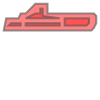

In [285]:
boat = submarine.Boat(game, 'A')
boat.geojson_boat()

In [124]:
radio_B.listen_enemy_move()

HEAD SOUTH


In [ ]:
central_circuit_yellow = [['mine_torpedo',1],['silence_scenario',1],['drone_sonar',1],['mine_torpedo',6]]
central_circuit_orange = [['silence_scenario',2],['mine_torpedo',2],['silence_scenario',3],['drone_sonar',5]]
central_circuit_grey = [['drone_sonar',4],['silence_scenario',4],['mine_torpedo',3],['silence_scenario',6]]
west_box = [['mine_torpedo',1],['silence_scenario',1],['drone_sonar',1],['drone_sonar',2],['radiation',1],['radiation',2]]
north_box = [['silence_scenario',2],['mine_torpedo',2],['silence_scenario',3],['drone_sonar',3],['mine_torpedo',3],['radiation',3]]
south_box = [['drone_sonar',4],['silence_scenario',4],['mine_torpedo',4],['mine_torpedo',5],['radiation',6],['silence_scenario',5]]
east_box = [['drone_sonar',5],['silence_scenario',6],['mine_torpedo',6],['radiation',5],['drone_sonar',6],['radiation',6]]

class Engineer:
    def __init__(self, game, team):
        self.team = team
        self.game = game

    